<a href="https://colab.research.google.com/github/hereagain-Y/TCR_VAE/blob/main/PairedCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install Biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 7.4 MB/s 


In [ ]:

from pkgutil import extend_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from six.moves import xrange
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
#
from scipy.spatial import distance
import random 

import random
from Bio import pairwise2
from Bio.Align import substitution_matrices
from scipy import spatial
from scipy import stats
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
AAs= ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
index_code = {}
code_index = {}
l_max = 20
for i in range(len(AAs)):
    index_code[i] = AAs[i]
    code_index[ AAs[i] ] = i

def oneHotEncode(seq, l_max=l_max, index_code=index_code, code_index=code_index):
    n_amino = 20
    matrix = np.zeros((l_max,n_amino)).astype(int)
    for i in range(len(seq)):
        matrix[ i , code_index[seq[i]] ] = 1
    return matrix

# pca encoded 
pca_index = pd.read_csv("/content/drive/My Drive/DL/VAE/AA_indexPCA.csv")
d=pca_index.set_index('Unnamed: 0').T.to_dict('list')


# pca normalization
data = d.items()
list_dat = list(d.values())
arr = np.array(list_dat)
ex = np.array(arr)
ex_norm = (ex-ex.min(axis=0))/(ex.max(axis=0)-ex.min(axis=0))

AAs=np.array(list(d.keys()))
new_pca = {}

for i in np.arange(20):
    new_pca[AAs[i]]=ex_norm[i]

new_pca
d= new_pca

def AAindexEncoding(Seq):
    length_seq=len(Seq)
    global l_max
    AAE=np.zeros([l_max,20])
    if length_seq<l_max:
        for amino in range(length_seq):
            AA=Seq[amino]# 
            AAE[amino,]=d[AA] # add PC value 
            
        for amino in range(length_seq,l_max):
            AAE[amino,]=np.zeros(20)
    else: 
        for amino in range(length_seq): # zero padding
            AA=Seq[amino]# 
            AAE[amino,]=d[AA]
        
    #AAE=np.transpose(AAE.astype(np.float32)) # row as PC. and column as AA sequence 
    return AAE 

  
def GetFeatures(file):
    hot_encode=[]
    for seq in file:
        hot_encode.append(AAindexEncoding(seq))
    hot_encode=np.array(hot_encode)
    result=np.array(hot_encode)
    return(result)

In [ ]:
matrix = substitution_matrices.load('BLOSUM62')
#from Bio.SubsMat import MatrixInfo as matlist
#matrix = matlist.blosum62
#in 80 max penalty for substitution is -6,
open_penalty = -4
gap_penalty = -4
#
def parseMatrix(m):
    re = {}
    alpha = m.alphabet
    for i in range(len(alpha)):
        for j in range(i,len(alpha)):
            re[(alpha[i],alpha[j])] = m[i,j]
    return re
align_matrix =  parseMatrix(substitution_matrices.load('BLOSUM62'))

In [ ]:
seq_test = pd.read_csv('/content/drive/My Drive/DL/VAE/NormalCDR3.txt',delimiter='\t',header=None,names=['seq'])
seq_test['length'] = [len(seq) for seq in seq_test['seq']]

seq_test = seq_test[ seq_test['length']<=20 ]
seq = list( seq_test['seq'] )
seq_x = random.sample(seq,10000)
seq_y = random.sample(seq,10000)

# alignment on x y 
score_align=[]
for i in range(len(seq_x)):
    
  alignments = pairwise2.align.localds(seq_x[i], seq_y[i], align_matrix, open=open_penalty, extend=gap_penalty)
  score_align.append(alignments[0].score)

AA_matx= GetFeatures(seq_x)
AA_maty= GetFeatures(seq_y)


#seq_train_x = AA_matx # 20*20
#seq_train_y = AA_maty

#train_data=[]
#for i in range(len(AA_matx)):
#  train_data.append([AA_matx[i],score_align[i]])
trainloader_x = torch.utils.data.DataLoader([ [torch.from_numpy(AA_matx[i]).float(),score_align[i]] for i in range(len(score_align))],  batch_size=1000)
#i1, l1 = next(iter(trainloader))
#print(l1.shape)
trainloader_y = torch.utils.data.DataLoader([ [torch.from_numpy(AA_matx[i]).float(),score_align[i]] for i in range(len(score_align))],  batch_size=1000)

In [ ]:
cuda = False
channels =1
device = torch.device("cuda" if cuda else "cpu")
batch_size = 1000
latent_dim = 32

lr = 1e-3

In [ ]:

class VAE(nn.Module):
    def __init__(self,h_dim=64*10*10, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=5, stride=1), #16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=1), # 12
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), #10
            nn.ReLU()
        
        )

        
        
        # mean 64*5*5 =
        self.fc1 = nn.Linear(h_dim, z_dim)
        # var 
        self.fc2 = nn.Linear(h_dim, z_dim)
        # for decoder layer 
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            
   
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu):
        #std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        #esp = torch.randn(*mu.size())
        z = mu
        return z
    
    def bottleneck(self, h):
        mu= self.fc1(h)
        z = self.reparameterize(mu)
        return mu, z
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0] # latent layer 

        
    
    #def alignmentscore(self,x,y):
    #    scores = pairwise2.align.localds(x,y,align_matrix,open=open_penalty,extend=gap_penalty)
    #    score_align = scores[0].score
    #    return score_align
        
    def latent(self,x,y):
        l1 = self.encoder(x)# 32
        l1 = l1.view(-1,64*10*10) # 32
        l1, mu1 = self.bottleneck(l1)

        l2 = self.encoder(y)# 32
        l2 = l2.view(-1,64*10*10) # 32
        l2, mu2 = self.bottleneck(l2)
        # use cos-simialrity
        #latent_dist =np.sqrt( np.sum(np.square(l1 - l2)) )
        
        
        return l1,l2

    def forward(self, x,y):
      # for dataset 1
        h1= self.encoder(x)
        h1 = h1.view(-1,64*10*10)
        z1, mu1 = self.bottleneck(h1) #
        z1 = self.fc3(z1) # 64*10*10
        z1 = z1.view(-1,64,10,10)
        z1 = self.decoder(z1)
      # for dat2   
        h2= self.encoder(y)
        h2 = h2.view(-1,64*10*10)
        z2, mu2 = self.bottleneck(h2)
        z2 = self.fc3(z2)
        z2 = z2.view(-1,64,10,10)
        z2 = self.decoder(z2)
        
        # aligment 
        #s = self.alignmentscore(x,y)
        # latent distance
        l1,l2 = self.latent(x,y)
        
        
        
        return z1, mu1,z2,mu2,l1,l2

In [ ]:
    
model = VAE(h_dim=64*10*10, z_dim=32).to(device)
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=lr)

def loss_function(reconx,x,recony,y,score,l1,l2):
    # reconstruction error:
    BCE_x =  nn.functional.binary_cross_entropy(reconx, x, reduction='sum')
    BCE_y = nn.functional.binary_cross_entropy(recony, y, reduction='sum')
    
    # pearson 
    #score =score.detach().numpy()
    #l1 = l1.detach().numpy
    #l2 = l2.detach().numpy
    #latent = np.sqrt( np.sum(np.square(l1 - l2)))
    #corr = stats.pearsonr(score,latent)[0]
    dist=torch.nn.functional.pairwise_distance(l1, l2)
    vx = score - torch.mean(score)
    vy = dist - torch.mean(dist)
    corr=torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))) # pearson
    
    
    
    return BCE_x + BCE_y +corr#+ corr, corr

In [ ]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc1): Linear(in_features=6400, out_features=32, bias=True)
  (fc2): Linear(in_features=6400, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=6400, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
    (5): Sigmoid()
  )
)


In [ ]:
epochs = 500

	Epoch 0 complete! 	Average Loss:  315.47218125
	Epoch 100 complete! 	Average Loss:  306.64525
	Epoch 200 complete! 	Average Loss:  304.243725
	Epoch 300 complete! 	Average Loss:  302.610378125
	Epoch 400 complete! 	Average Loss:  301.55076875
Finish!!
plot curves
==train end===
==train end===


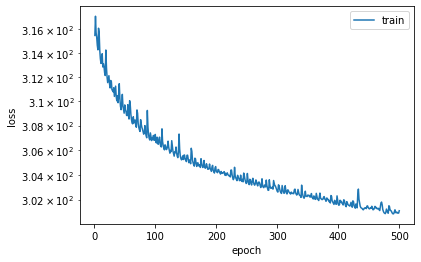

In [ ]:
def plotCurve(x_vals,y_vals,x_label, y_label,
              legend=None,figsize=(3.5,2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    
    if legend:
        plt.legend(legend)

model.train()
train_loss= []
testtoal_loss= []
for epoch in range(epochs):
    overall_loss = 0
    overall_testloss= 0
    for batch_idx, data in enumerate(zip(trainloader_x,trainloader_y)):
        x= data[0][0]
        y= data[1][0]
        score = data[0][1]
        x = x.view(1000, 1,20,20)
        y = y.view(1000,1,20,20)
        x = x.to(device)
        y = y.to(device)
        #zero grad
        optimizer.zero_grad()
        #----
        x_hat, mean_x,y_hat,mean_y,l1,l2= model(x,y)
        #l1 = l1.cpu().detach().numpy()
        #l2 = l2.cpu().detach().numpy()
        #dist = (l1-l2).pow(2).sum(3).sqrt()
        #xx = l1.reshape(2,-1)
        #yy = l2.reshape(2,-1)

        #latent = 1-spatial.distance.cosine(l1, l2)
        #corr = stats.pearsonr(score,dist)[0]
        #corr = torch.corrcoef()

        

        loss = loss_function(x_hat,x,y_hat,y,score,l1,l2)
        overall_loss += loss.item()  
        #back prog
        loss.backward()     
        optimizer.step()
       
    if (epoch % 100 == 0):
          #print('====> Epoch %d done! Average Loss:  = %.2e, Average test loss = %.2e' % (epoch,overall_loss / (batch_idx*batch_size),overall_testloss/(batch_idx*batch_size)))
        
        
      print("\tEpoch", epoch , "complete!", "\tAverage Loss: ", overall_loss / len(AA_matx))#overall_loss / (batch_idx*batch_size),

    train_loss.append( overall_loss / len(AA_matx) )


torch.save(model, '/content/drive/MyDrive/DL/CNNVAE/Paired_sigmoid_modified_1000_echo_cat_train.apx')
print("Finish!!")    
print("plot curves")
plotCurve(range(1,epochs+1),train_loss,"epoch","loss",
         
          ['train'])
print('==train end===')   
print('==train end===')   

